# A toy problem

Try to measure $\theta$, the mean of a gaussian, as accurately as possible. Variance of the gaussian is set by $\phi$, an experimental parameter.

In [1]:
%matplotlib inline

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt

In [2]:
def simulator(theta, phi, n_samples=100):
    return np.random.normal(loc=theta, scale=2 + np.sin(phi), size=n_samples)

def collect_data(phi, n_samples=100):
    # 3.141 is the unknown parameter we are trying to measure
    # best experimental setting is 3pi/2 (or any multiple of it)
    return simulator(3.141, phi, n_samples)

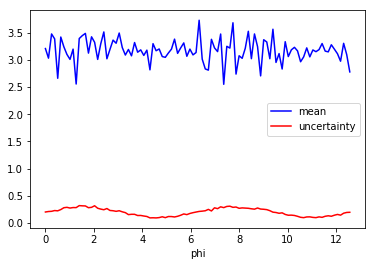

In [3]:
# for a simple problem like this we can scan phi and simply calculate the mean
# and standard error on the mean
# In a real setting we want to minimize the number of:
# * real experiments run (expensive)
# * simulated experiments (less expensive than real but not cheap)

phis = np.linspace(0, 4*np.pi, 100)
means = []
uncertainties = []
for phi in phis:
    data = collect_data(phi)
    sem = np.std(data) / np.sqrt(len(data))
    means.append(np.mean(data))
    uncertainties.append(sem)
    
plt.plot(phis, means, 'b', label='mean')
plt.plot(phis, uncertainties, 'r', label='uncertainty')
plt.xlabel('phi')
plt.legend(loc='best')

Algorithm:

initialise : theta, phi

1. perform real experiment at current best $\phi$
1. infer $\theta^*$
1. given $\theta^*$ find best $\phi$
1. go to 1.

In [4]:
from skopt import Optimizer
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel
from skopt.learning.gaussian_process.kernels import Matern

In [5]:
phis = []
uncertainties = []


cov_amplitude = ConstantKernel(1.0, (0.01, 1000.0))
other_kernel = Matern(
    length_scale=np.ones(1),
    length_scale_bounds=[(0.01, 100)],
    nu=2.5)
base_estimator = GaussianProcessRegressor(
    kernel=cov_amplitude * other_kernel,
    normalize_y=True, alpha=0.0, noise="gaussian",
    n_restarts_optimizer=2)
optimizer = Optimizer([(0., 2*np.pi)], base_estimator, n_random_starts=5)

phi = optimizer.ask()
print("Initial experimental settings:", phi)

for n in range(40):
    data = collect_data(phi)
    
    # evaluate the "quality" of this experimental setting
    # in the simple example this is just the SEM
    sem = np.std(data) / np.sqrt(len(data))

    phis.append(phi)
    uncertainties.append(sem)
    
    # Pick next experimental setting
    optimizer.tell(phi, sem)
    phi = optimizer.ask()

Initial experimental settings: [4.2171506171963706]


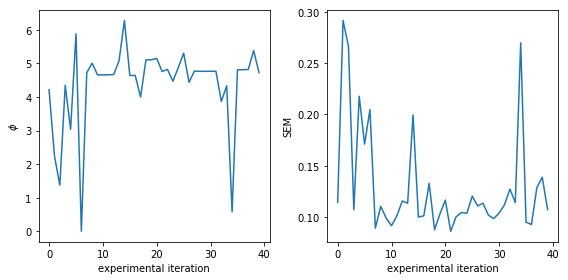

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(phis)
axs[0].set_ylabel("$\phi$")
axs[1].plot(uncertainties)
axs[1].set_ylabel("SEM")
axs[0].set_xlabel("experimental iteration")
axs[1].set_xlabel("experimental iteration")
plt.tight_layout()

## Likelihood free inference

In general we can not compute the uncertainty directly. Information gain becomes the measure of quality/uncertainty.

In [7]:
from scipy.stats import entropy

In [23]:
class Distribution:
    def __init__(self, samples=None, bins=22, range=(-8, 14)):
        self._densities, self._edges = np.histogram(samples, bins=bins, range=range,
                                                    density=True)
    @property
    def probabilities(self):
        # clip bins which are zero
        return self._densities.clip(min=0.0000000001)

In [24]:
datas = simulator(3.1, 1, n_samples=10000)
d1 = Distribution(datas)
#d2 = Distribution(simulator(3.1, 3.5, n_samples=10000))

In [33]:
def pmap(data, theta_map, phi):
    ret = 0.
    d = Distribution(simulator(theta_map, phi, n_samples=10000))
    probs = d.probabilities
    for point in data:
        idx = np.searchsorted(d._edges, point) - 1
        if idx == -1:
            idx = 0
        if idx == len(probs):
            idx -= 1
        ret += probs[idx]
    return ret/len(data)

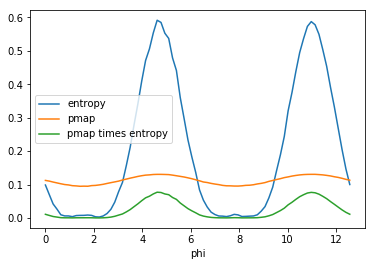

In [36]:
phis = np.linspace(0, 4*np.pi, 80)
entropies = [entropy(Distribution(simulator(3.1, phi, n_samples=10000)).probabilities,
                     d1.probabilities)
             for phi in phis]
plt.plot(phis, entropies, label='entropy')

pmap_ = [pmap(datas, np.mean(datas), phi) for phi in phis]
pmap_times_entropy = [pmap_[i] * entropies[i] for i in range(len(phis))]
plt.plot(phis, pmap_, label='pmap')
plt.plot(phis, pmap_times_entropy, label='pmap times entropy')
plt.xlabel('phi')
plt.legend(loc='best')

In [37]:
1.5*np.pi

4.71238898038469